In [90]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

def load_json(file_path): 
    """Load and return a JSON object from a file."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File not found -> {file_path}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in file {file_path}: {e}")
    return None


def update_json(data, key, value): # Modify/Add Data
    data[key] = value
    return data

def save_json(file_path, data): # Save JSON Data
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import matplotlib.patheffects
import math

### Helper Functions ###
def categorize_samples_suberror(json_file, sample_choices):
    """
    Categorize each sample as:
    - agree_no_error
    - agree_missing_phase
    - agree_parsing_error
    - agree_missing_interpretation
    - disagree_no_error
    - disagree_missing_phase
    - dissagree_parsing_error
    - disagree_missing_interpretation
    - also if it is missing/adding an interpretation and a phase or more
    """
    result = {}
    for sample in json_file:
        # Determine agree/disagree
        #Even if it is an error that doesn't allow for this, I still have it, it won't affect the final graphs as long as both categories are the same (agree/disagree)
        if sample_choices[sample]["llama_choice"] == sample_choices[sample]["chat_choice"]:
            base = "agree"
        else:
            base = "disagree"
        # Check for errors
        error = None
        num_interprets = len(list(json_file[sample].keys())) - 1
        count = 0
        for interpret in json_file[sample]:
            if interpret == "Synth_Conditions":
                continue
            info = json_file[sample][interpret]
            if "LLM_interpretation_likelihood_llama" not in info:
                count += 1 
                if error == "missing_phase":
                    error = "missing_interpretation_phase"
                else:
                    error = "missing_interpretation"
                if count == num_interprets:
                    error = "parsing_error"
                continue
            phases_llama = list(info["LLM_phases_likelihood_llama"].keys())
            weightfractions = info["weight_fraction"]
            if len(phases_llama) != len(weightfractions):
                error = "missing_phase"
                break
        if error is None:
            result[sample] = f"{base}_no_error"
        elif error == "missing_phase":
            result[sample] = f"{base}_missing_phase"
        elif error == "missing_interpretation":
            result[sample] = f"{base}_missing_interpretation"
        elif error == "missing_interpretation_phase":
            result[sample] = f"{base}_missing_interpretation_phase"
        elif error == "parsing_error":
            result[sample] = f"{base}_parsing_error"
    return result

def count_subcategories(categorized):
    # sums out the categories for dissagree and agree cases including subcategories with errors
    agree_no_error = sum(1 for v in categorized.values() if v == "agree_no_error")
    agree_missing_phase = sum(1 for v in categorized.values() if v == "agree_missing_phase")
    disagree_no_error = sum(1 for v in categorized.values() if v == "disagree_no_error")
    disagree_missing_phase = sum(1 for v in categorized.values() if v == "disagree_missing_phase")
    missing_interpretation = sum(1 for v in categorized.values() if v == "disagree_missing_interpretation") + sum(1 for v in categorized.values() if v == "agree_missing_interpretation")
    parsing_error = sum(1 for v in categorized.values() if v == "agree_parsing_error")+ sum(1 for v in categorized.values() if v == "disagree_parsing_error")
    missing_interpretation_phase = sum(1 for v in categorized.values() if v == "agree_missing_interpretation_phase")+ sum(1 for v in categorized.values() if v == "disagree_missing_interpretation_phase")
    return [
        agree_no_error, agree_missing_phase,
        disagree_no_error, disagree_missing_phase, missing_interpretation, missing_interpretation_phase, parsing_error
    ]
def samples_choices(json_file):
    #returns llama and chat gpt sample choices from the json file
    sample_choice = {}
    for sample in json_file:
        sample_choice[sample] = {}
        llama_probs = []
        chat_probs = []
        for interpretation in json_file[sample]:
            if interpretation != "Synth_Conditions":
                if "unnormalized_posterior_llama" in json_file[sample][interpretation]:
                    llama_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior_llama"]))
                    chat_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior"]))
                else:
                    chat_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior"]))
        if llama_probs:
            llama_choice = max(llama_probs, key=lambda x: x[1])[0]
        else:
            llama_choice = "I_1 (oops)"
        chat_choice = max(chat_probs, key=lambda x: x[1])[0]
        sample_choice[sample]["llama_choice"] = llama_choice
        sample_choice[sample]["chat_choice"] = chat_choice

    return sample_choice
def count_agree(sample_choice):
    # uses the output of the sample choices function to count all agree and dissagree samples 
    agree = 0 
    disagree = 0 
    for sample, choices in sample_choice.items():
        if choices["chat_choice"] == choices["llama_choice"]:
            agree += 1
        else: disagree += 1
    return [agree, disagree]

### Main Function ###
def graph_all_with_suberrors(json_files, run_labels=None, y_val=1.04):
    
    """
    Creates a graph with all runs in json_files and then excluding runs with missing interpretations, 
    it averages out the agree and dissagree and other subcategories into a final graph 
    """

    n_runs = len(json_files)
    
    colors = [
        "#2874a6",  # agree_no_error (blue)
        "#2874a6",  # agree_missing_phase (blue, hatched)
        "#b03a2e",  # disagree_no_error (red)
        "#b03a2e",  # disagree_missing_phase (red, hatched)
        "#c0c0c0",  # missing_interpretation (grey and reverse hatched)
        "#c0c0c0",  # missing_interpretation_phase (grey and xx)
        "#c0c0c0",  # parsing_error (grey)


    ]
    hatches = [
        None,        # agree_no_error
        "//",        # agree_missing_phase
        None,        # disagree_no_error
        "//",        # disagree_missing_phase
        "\\\\",        # missing_interpretation
        "xx",        # missing_interpretation_phase
        None         # parsing_error
    ]
    labels = [
        "Agree", "Agree (Missing Phase)",
        "Disagree", "Disagree (Missing Phase)", "Missing Interpretation", "Missing/Extra Phase and Interpretations", "Data Extraction Error"
    ]

    all_data = []
    for json_file in json_files:
        sample_choices = samples_choices(json_file)
        categorized = categorize_samples_suberror(json_file, sample_choices)
        counts = count_subcategories(categorized)
        # counts = [agree_no_error, agree_missing_phase, disagree_no_error, disagree_missing_phase, missing_interpretation, missing_interpretation_phase, parsing_error]
        all_data.append(counts)
    #label subplots
    flag = [] # useful to catch which runs have a missing interpretation 
    flag_message = "(Incomplete Data)"
    if run_labels is None:
        run_labels =[]
        flag = []
        for i in range(n_runs):
            if all_data[i][4] != 0 or all_data[i][5] != 0 or all_data[i][6] != 0:
                run_labels.append(f"Run {i+1} " + flag_message)
                flag.append(i)
            else:
                run_labels.append(f"Run {i+1}")

    # Add average
    avg = [round(np.mean([all_data[d][i] for d in range(len(all_data)) if d not in flag]),2) for i in range(len(all_data[0]))]
    data_std = [all_data[d][0]+all_data[d][1] for d in range(len(all_data)) if d not in flag]
    std = round(np.std(data_std),2)
    all_data.append(avg)
    run_labels.append(f"Average\n(" + r'$\sigma$' + f" = {std} Samples)")

    # Dynamic grid: 2 columns for runs, as many rows as needed, average in last column, centered
    n_run_plots = len(json_files)
    n_rows = 2
    n_columns = math.ceil((n_run_plots + 1)/2)
    fig = plt.figure(figsize=(3*(2+1), 3*n_rows))
    gs = fig.add_gridspec(n_rows, n_columns, width_ratios=[1, 1, 1.1], wspace=0.3, hspace=0.3)

    axes = []
    # Place run plots
    for idx in range(n_run_plots):
        row = idx % 2
        col = idx // 2
        axes.append(fig.add_subplot(gs[row, col]))
    # Place average plot in last column, vertically centered
    avg_row = n_rows // 2 if n_rows > 1 else 0
    axes.append(fig.add_subplot(gs[avg_row, 2]))

    for i, (ax, data, run_label) in enumerate(zip(axes, all_data, run_labels)):
        wedges, _ = ax.pie(
            data,
            wedgeprops=dict(width=0.5),
            startangle=90,
            colors=colors,
        )
        # Add hatches for error sections
        for j, wedge in enumerate(wedges):
            if hatches[j]:
                wedge.set_hatch(hatches[j])
        # Annotate (outside, no background, skip zeros)
        for j, p in enumerate(wedges):
            if data[j] == 0:
                continue
            number = data[j]
            ang = (p.theta2 + p.theta1) / 2.
            r = 1.25  # slightly outside the donut
            x = r * np.cos(np.deg2rad(ang))
            y = r * np.sin(np.deg2rad(ang))
            ax.annotate(
                f"{number}",
                xy=(x, y),
                ha="center",
                va="center",
                fontsize=10,
                color="black",
            )
        # Calculate agree/disagree counts for center text
        agree_count = data[0] + data[1]
        disagree_count = data[2] + data[3]
        total = agree_count + disagree_count
        if flag_message not in run_label:
            center_text = f"{int(agree_count)}/{int(total)}"
        else: 
            center_text = f"--/--"
        ax.text(0, 0, center_text, ha='center', va='center', fontsize=12,fontweight='bold', color='black')
        
        ax.set_title(run_label, fontsize=13, fontweight='bold',pad=13)

    ### Set legend ###
    num_columns = len(all_data[0]) # this section totals up all sections to see which legend patches should be included in the plot
    all_run_totals = [0] * num_columns
    for row in all_data:
        for i in range(num_columns):
            all_run_totals[i] += row[i]
    legend_patches = []
    if all_run_totals[0] or all_run_totals[1]:
        legend_patches.append(Patch(facecolor="#2874a6", label="Agree"))
    if all_run_totals[2] or all_run_totals[3]:
        legend_patches.append(Patch(facecolor="#b03a2e", label="Disagree"))
    if all_run_totals[1] or all_run_totals[3]:
        legend_patches.append(Patch(facecolor="none", label="Missing/Extra Phases", hatch="//", edgecolor="black"))
    if all_run_totals[4]:
        legend_patches.append(Patch(facecolor="#c0c0c0", label="Missing Interpretation", hatch="\\\\", edgecolor="black"))
    if all_run_totals[5]:
        legend_patches.append(Patch(facecolor="#c0c0c0", label="Phase + Interpretation Errors", hatch="xx", edgecolor="black"))
    if all_run_totals[6]:
        legend_patches.append(Patch(facecolor="#c0c0c0", label="Data Extraction Error", edgecolor="black"))
    
    fig.legend(
        handles=legend_patches,
        loc='lower center',
        bbox_to_anchor=(0.5, 0.0),
        ncol=2,
        fontsize=11,
        frameon=True,
        fancybox=True,
    )
    fig.suptitle("AIF Agreement & LLM Response Error Subcategories\n(15 Samples)", fontsize=15,fontweight='bold',y=y_val)
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()

/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_7725/1842822650.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


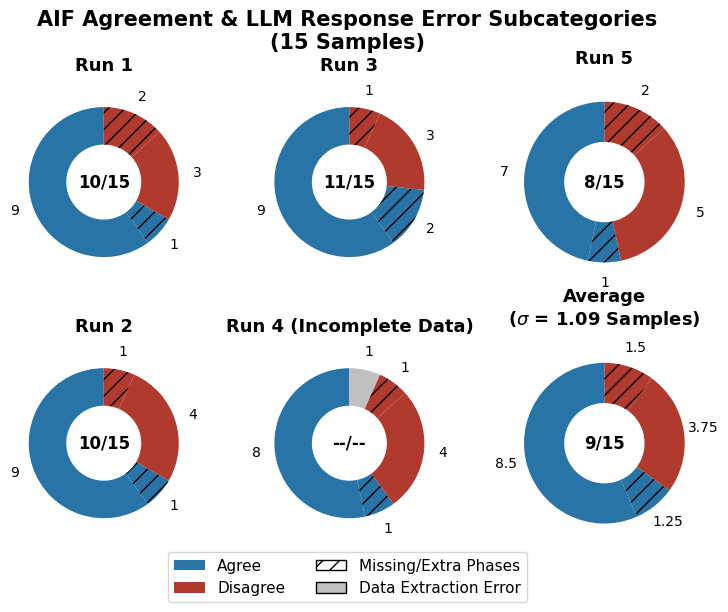

In [92]:
json_file1_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama1.json"
json_file2_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama2.json"
json_file3_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama3.json"
json_file4_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama4.json"
json_file5_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama5.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)
json_file5 = load_json(json_file5_path)

graph_all_with_suberrors([json_file1,json_file2,json_file3,json_file4,json_file5],y_val=1)

/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_7725/1842822650.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


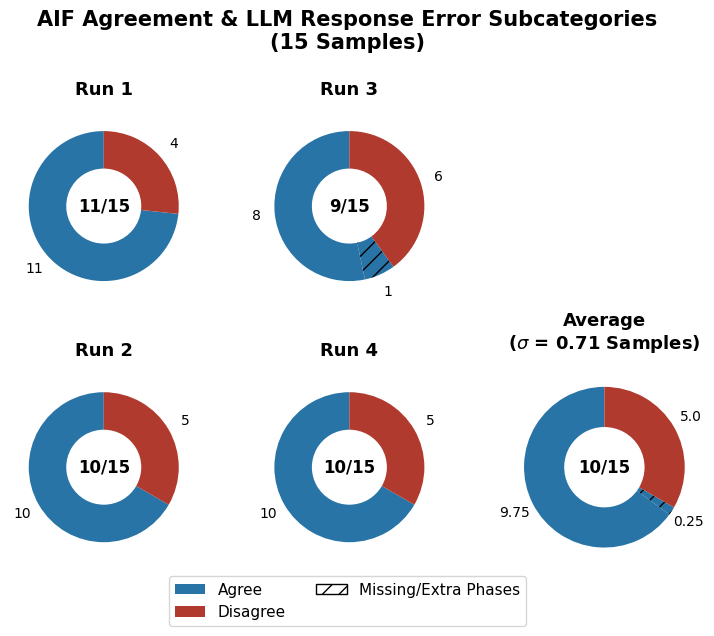

In [93]:
json_file1_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v3_llama1(183).json"
json_file2_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v3_llama2(184).json"
json_file3_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v3_llama3(185).json"
json_file4_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v3_llama4(186).json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)

graph_all_with_suberrors([json_file1,json_file2,json_file3,json_file4])

In [115]:
import matplotlib.gridspec as gridspec
import math

# *** Just Like previous AIF agreement graph, but the average graph is a seperate plot, background is clear ***

### Helper Functions ### 
def create_run_axes(n_runs, run_width=3.5, run_height=3):

    
    if n_runs <= 3:
        rows = 1
        cols = n_runs
    else:
        rows = 2
        cols = math.ceil(n_runs / 2)

    fig_width = run_width * cols
    fig_height = run_height * rows
    fig = plt.figure(figsize=(fig_width, fig_height))
    gs = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)

    axes = []
    for i in range(n_runs):
        row = i // cols
        col = i % cols
        if rows == 2 and n_runs > 3:
            # Spread evenly for 5 elements: 3 on top, 2 on bottom (centered)
            if n_runs == 5 and row == 1:
                col += 0.5  # Center bottom row elements
        axes.append(fig.add_subplot(gs[row, int(col)]))

    # Make pie charts round
    for ax in axes:
        ax.set_aspect('equal')

    return fig, axes

### Main Function ### 
def allgraphs_seperate_suberrors(json_files, run_labels=None, y_val=1.04,title_average="Average Agreement & Errors\n(15 Samples)"):
    """
    Creates one figure with all individual runs, and a separate figure showing the average graph.
    Most updated function for this (other function with white background may not have all information updated)
    """



    n_runs = len(json_files)
    
    colors = [
        "#2874a6",  # agree_no_error (blue)
        "#2874a6",  # agree_missing_phase (blue, hatched)
        "#b03a2e",  # disagree_no_error (red)
        "#b03a2e",  # disagree_missing_phase (red, hatched)
        "#c0c0c0",  # missing_interpretation (grey and reverse hatched)
        "#c0c0c0",  # missing_interpretation_phase (grey and xx)
        "#c0c0c0",  # parsing_error (grey)


    ]
    hatches = [
        None,        # agree_no_error
        "//",        # agree_missing_phase
        None,        # disagree_no_error
        "//",        # disagree_missing_phase
        "\\\\",        # missing_interpretation
        "xx",        # missing_interpretation_phase
        None         # parsing_error
    ]

    all_data = []
    for json_file in json_files:
        sample_choices = samples_choices(json_file)
        categorized = categorize_samples_suberror(json_file, sample_choices)
        counts = count_subcategories(categorized)
        all_data.append(counts)

    # Track which runs are missing interpretation
    flag = []
    flag_message = "(Incomplete Data)"
    if run_labels is None:
        run_labels = []
        for i in range(n_runs):
            if all_data[i][4] != 0 or all_data[i][5] != 0 or all_data[i][6]:
                run_labels.append(f"Run {i+1} {flag_message}")
                flag.append(i)
            else:
                run_labels.append(f"Run {i+1}")

    # Calculate average (excluding flagged runs)
    avg = [round(np.mean([all_data[d][i] for d in range(n_runs) if d not in flag]),2) for i in range(len(all_data[0]))]
    data_std = [all_data[d][0] + all_data[d][1] for d in range(n_runs) if d not in flag]
    std = round(np.std(data_std), 2)
    avg_label = f"(" + r'$\sigma$' + f" = {std})"

    ### FIGURE 1: Individual Runs ###
    fig, axes = create_run_axes(n_runs=len(json_files), run_width=3.2, run_height=2.7)

    # set graphs
    for i, (ax, data, run_label) in enumerate(zip(axes, all_data, run_labels)):
        wedges, _ = ax.pie(
            data,
            wedgeprops=dict(width=0.5),
            startangle=90,
            colors=colors,
        )
        for j, wedge in enumerate(wedges):
            if hatches[j]:
                wedge.set_hatch(hatches[j])
        for j, p in enumerate(wedges):
            if data[j] == 0:
                continue
            ang = (p.theta2 + p.theta1) / 2.
            r = 1.25
            x = r * np.cos(np.deg2rad(ang))
            y = r * np.sin(np.deg2rad(ang))
            ax.annotate(f"{data[j]}", xy=(x, y), ha="center", va="center", fontsize=10, color="black")

        agree_count = data[0] + data[1]
        disagree_count = data[2] + data[3]
        total = agree_count + disagree_count
        center_text = f"{int(agree_count)}/{int(total)}" if flag_message not in run_label else "--/--"
        ax.text(0, 0, center_text, ha='center', va='center', fontsize=12, fontweight='bold')

        ax.set_title(run_label, fontsize=13, fontweight='bold', pad=13)

    fig.suptitle(
        "AIF Agreement & LLM Response Error Subcategories\n(15 Samples)",
        fontsize=15,
        fontweight='bold',
        y=1.1,  # slightly above top
        x=0.5,   # explicitly center
    )
    fig.subplots_adjust(top=0.93, bottom=0.15)  # tighter layout

    ### Set legend ###
    num_columns = len(all_data[0]) # this section totals up all sections to see which legend patches should be included in the plot
    all_run_totals = [0] * num_columns
    for row in all_data:
        for i in range(num_columns):
            all_run_totals[i] += row[i]
    legend_patches = []
    if all_run_totals[0] or all_run_totals[1]:
        legend_patches.append(Patch(facecolor="#2874a6", label="Agree"))
    if all_run_totals[2] or all_run_totals[3]:
        legend_patches.append(Patch(facecolor="#b03a2e", label="Disagree"))
    if all_run_totals[1] or all_run_totals[3]:
        legend_patches.append(Patch(facecolor="none", label="Missing/Extra Phases", hatch="//", edgecolor="black"))
    if all_run_totals[4]:
        legend_patches.append(Patch(facecolor="#c0c0c0", label="Missing Interpretation", hatch="\\\\", edgecolor="black"))
    if all_run_totals[5]:
        legend_patches.append(Patch(facecolor="#c0c0c0", label="Phase + Interpretation Errors", hatch="xx", edgecolor="black"))
    if all_run_totals[6]:
        legend_patches.append(Patch(facecolor="#c0c0c0", label="Data Extraction Error", edgecolor="black"))
    
    fig.legend(
        handles=legend_patches,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=2,
        fontsize=11,
        frameon=True,
        fancybox=True,
    )
    fig.patch.set_alpha(0)
    # plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()

    ### FIGURE 2: Average ###
    fig2, ax = plt.subplots(figsize=(4, 4))
    wedges, _ = ax.pie(
        avg,
        wedgeprops=dict(width=0.5),
        startangle=90,
        colors=colors,
    )
    for j, wedge in enumerate(wedges):
        if hatches[j]:
            wedge.set_hatch(hatches[j])
    for j, p in enumerate(wedges):
        if avg[j] == 0:
            continue
        ang = (p.theta2 + p.theta1) / 2.
        r = 1.25
        x = r * np.cos(np.deg2rad(ang))
        y = r * np.sin(np.deg2rad(ang))
        ax.annotate(f"{round(avg[j],2)}", xy=(x, y), ha="center", va="center", fontsize=10, color="black")

    agree_count = avg[0] + avg[1]
    disagree_count = avg[2] + avg[3]
    total = agree_count + disagree_count
    ax.text(0, 0, f"{int(agree_count)}/{int(total)}", ha='center', va='center', fontsize=12, fontweight='bold')

    ax.set_title(avg_label, fontsize=13, fontweight='bold', pad=10)
    fig2.suptitle(title_average, fontsize=15, fontweight='bold', y=.98)
    fig2.patch.set_alpha(0)
    fig2.legend(
        handles=legend_patches,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.07),
        ncol=2,
        fontsize=11,
        frameon=True,
        fancybox=True,
    )
    plt.tight_layout(rect=[0, 0.08, 1, 0.98])
    
    plt.show()


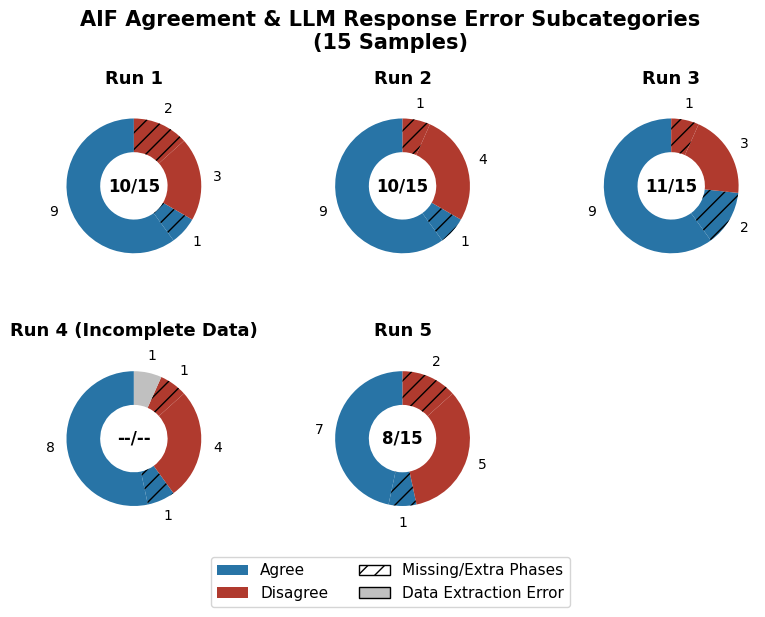

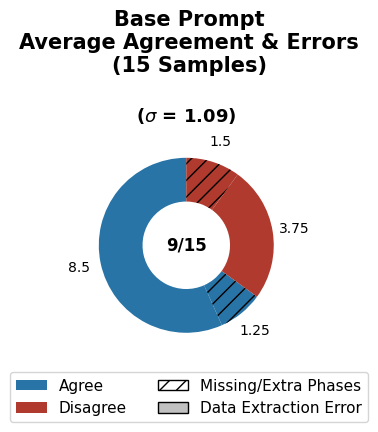

In [95]:
json_file1_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama1.json"
json_file2_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama2.json"
json_file3_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama3.json"
json_file4_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama4.json"
json_file5_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v1_llama5.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)
json_file5 = load_json(json_file5_path)

allgraphs_seperate_suberrors([json_file1,json_file2,json_file3,json_file4,json_file5],y_val=1,title_average="Base Prompt\nAverage Agreement & Errors\n(15 Samples)")

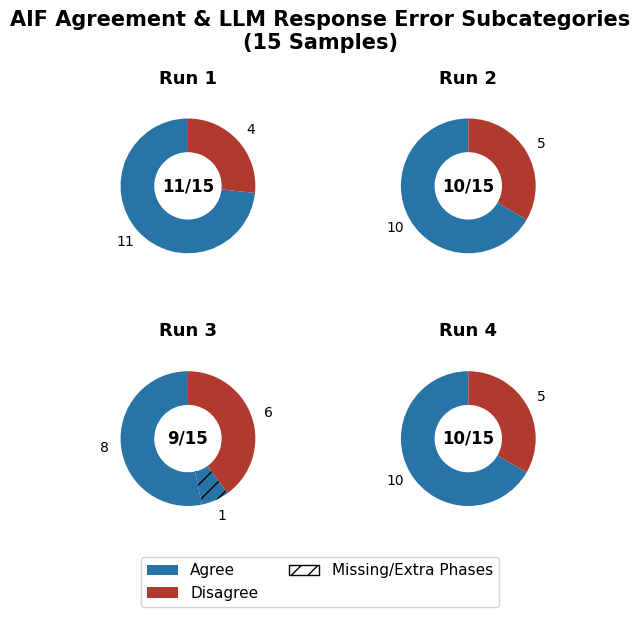

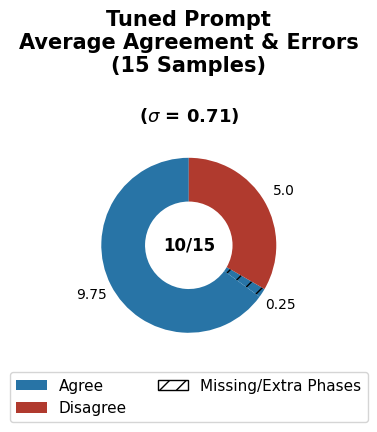

In [96]:
json_file1_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v3_llama1(183).json"
json_file2_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v3_llama2(184).json"
json_file3_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v3_llama3(185).json"
json_file4_path = "/Users/admin/Documents/GitHub/LLM_XRD_Interpretation_Validation/Data/prompt3/interpretations_llm_v3_llama4(186).json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)

allgraphs_seperate_suberrors([json_file1,json_file2,json_file3,json_file4],title_average="Tuned Prompt\nAverage Agreement & Errors\n(15 Samples)")

In [97]:
import pandas as pd

# *** Formats all AIF choices and low Rwp choices in a table with relevant information for a given json_file ***

### Helper Functions ### 
def find_all_choices(json_file, sample):
    sample_choice = {}
    llama_probs = []
    chat_probs = []
    rwp_vals = []
    sample_choice[sample] = {}
    for interpret, info in json_file[sample].items():
        if interpret == "Synth_Conditions":
            continue
        try:
            llama_score = info["unnormalized_posterior_llama"]
            chat_score = info["unnormalized_posterior"]
            rwp = info["rwp"]
            if all(isinstance(x, (int, float)) for x in [llama_score, chat_score, rwp]):
                llama_probs.append((interpret, llama_score))
                chat_probs.append((interpret, chat_score))
                rwp_vals.append((interpret, rwp))
        except KeyError as e:
            print(f"Missing key in sample '{sample}', interpretation '{interpret}': {e}")
        
        sample_choice[sample]["llama_choice"] = max(llama_probs, key=lambda x: x[1])[0] if llama_probs else None
        sample_choice[sample]["chat_choice"] = max(chat_probs, key=lambda x: x[1])[0] if chat_probs else None
        sample_choice[sample]["rwp_choice"] = min(rwp_vals, key=lambda x: x[1])[0] if rwp_vals else None
    
    return sample_choice

def format_predicted_phases(json_file, sample_id, chat_choice): 
    # Format the predicted phases with the weight fraction to be used in a table
    phases = json_file[sample_id][chat_choice]["phases"]
    wfs = json_file[sample_id][chat_choice]["weight_fraction"]
    wfs = [round(wf, 3) for wf in wfs]
    phase_list = ""
    for i in range(len(phases)):
        if not phase_list:
            phase_list += f"({phases[i]} {wfs[i]}%)"
        else: phase_list += f", ({phases[i]} {wfs[i]}%)"
    return phase_list

# ** Assembles a data frame with all relevant data for each sample **
def assemble_df(sample_id, sample_choice, json_file):
    """
    Can be used in the display_all_choice_data to look at all samples in json file 
    or called independently to look at the data for a single sample  
    """
    rows = []
    # assign a row to name the sample being run 
    name_row = {}
    name_row["Selection Method"] = sample_id
    name_row["Choice"] = ""
    name_row["Predicted Phases"] = ""
    name_row["Balance Score"] = ""
    name_row["Rwp"] = ""
    name_row["Chat GPT Likelihood"] = ""
    name_row["Llama Likelihood"] = ""

    # assign Chat GPT row values
    chat_row = {}
    chat_choice = sample_choice[sample_id]["chat_choice"]
    chat_row["Selection Method"] = "Chat GPT"
    chat_row["Choice"] = chat_choice
    chat_row["Predicted Phases"] = format_predicted_phases(json_file, sample_id, chat_choice)
    chat_row["Balance Score"] = round(json_file[sample_id][chat_choice]["balance_score"],3)
    chat_row["Rwp"] = json_file[sample_id][chat_choice]["rwp"]
    chat_row["Chat GPT Likelihood"] = json_file[sample_id][chat_choice]["LLM_interpretation_likelihood"]
    chat_row["Llama Likelihood"] = json_file[sample_id][chat_choice]["LLM_interpretation_likelihood_llama"]

    #assign Llama row values
    llama_row = {}
    llama_choice = sample_choice[sample_id]["llama_choice"]
    llama_row["Selection Method"] = "Llama"
    llama_row["Choice"] = llama_choice
    llama_row["Predicted Phases"] = format_predicted_phases(json_file, sample_id, llama_choice)
    llama_row["Balance Score"] = round(json_file[sample_id][llama_choice]["balance_score"],3)
    llama_row["Rwp"] = json_file[sample_id][llama_choice]["rwp"]
    llama_row["Chat GPT Likelihood"] = json_file[sample_id][llama_choice]["LLM_interpretation_likelihood"]
    llama_row["Llama Likelihood"] = json_file[sample_id][llama_choice]["LLM_interpretation_likelihood_llama"]

    #assign lowest Rwp values
    rwp_row = {}
    rwp_choice = sample_choice[sample_id]["rwp_choice"]
    rwp_row["Selection Method"] = "Lowest Rwp"
    rwp_row["Choice"] = rwp_choice
    rwp_row["Predicted Phases"] = format_predicted_phases(json_file, sample_id, rwp_choice)
    rwp_row["Balance Score"] = round(json_file[sample_id][rwp_choice]["balance_score"],3)
    rwp_row["Rwp"] = json_file[sample_id][rwp_choice]["rwp"]
    rwp_row["Chat GPT Likelihood"] = json_file[sample_id][rwp_choice]["LLM_interpretation_likelihood"]
    rwp_row["Llama Likelihood"] = json_file[sample_id][rwp_choice]["LLM_interpretation_likelihood_llama"]
    rows = [name_row, chat_row, llama_row, rwp_row]
    return rows
def display_all_choice_data(json_file):
    rows = []
    for sample_id in json_file.keys(): # go through every sample and display a chart with relevant information 
        sample_choice = find_all_choices(json_file, sample_id)
        rows.extend(assemble_df(sample_id, sample_choice, json_file))
    pd.set_option('display.max_colwidth', None)
    df = pd.DataFrame(rows)
    df = df[["Selection Method", "Choice", "Predicted Phases", "Balance Score", "Rwp", "Chat GPT Likelihood", "Llama Likelihood"]]
    display(df)


In [98]:
file_path = "../Data/prompt3/interpretations_llm_v1_llama5.json"
json_file = load_json(file_path)

display_all_choice_data(json_file)

,Selection Method,Choice,Predicted Phases,Balance Score,Rwp,Chat GPT Likelihood,Llama Likelihood
0,PG_1048_1,,,,,,
1,Chat GPT,I_3,"(V2O5_59 51.188%), (V3Cr7O15_167 48.812%), (Cr2O3_167 0.0%)",0.974,4.74,0.7,0.8
2,Llama,I_3,"(V2O5_59 51.188%), (V3Cr7O15_167 48.812%), (Cr2O3_167 0.0%)",0.974,4.74,0.7,0.8
3,Lowest Rwp,I_1,"(V20CrO52_59 4.341%), (V3Cr7O15_167 46.84%), (Cr2O3_167 0.0%), (V2O5_59 48.82%)",0.971,4.6,0.55,0.6
4,ARR_39,,,,,,
5,Chat GPT,I_1,(Ga33O50_12 100.0%),0.375,20.11,0.35,0.4
6,Llama,I_2,(Ga2O3_12 100.0%),0.375,20.14,0.35,0.6
7,Lowest Rwp,I_1,(Ga33O50_12 100.0%),0.375,20.11,0.35,0.4
8,TRI_62,,,,,,
9,Chat GPT,I_7,"(Li14V43O114_11 78.118%), (LiVO3_15 21.882%)",0.999,4.36,0.75,0.7


In [99]:
def find_all_choices(json_file):
    """ 
    Edited find_all_choices to return a ranked list of all interpretations ranked by AIF
    """
    sample_choice = {}
    for sample in json_file.keys():
        llama_probs = []
        chat_probs = []
        rwp_vals = []
        sample_choice[sample] = {}
        for interpret, info in json_file[sample].items():
            if interpret == "Synth_Conditions":
                continue
            try:
                llama_score = info["unnormalized_posterior_llama"]
                chat_score = info["unnormalized_posterior"]
                rwp = info["rwp"]
                if all(isinstance(x, (int, float)) for x in [llama_score, chat_score, rwp]):
                    llama_probs.append((interpret, llama_score))
                    chat_probs.append((interpret, chat_score))
                    rwp_vals.append((interpret, rwp))
            except KeyError as e:
                print(f"Missing key in sample '{sample}', interpretation '{interpret}': {e}")
        
        sample_choice[sample]["llama_choice"] = sorted(llama_probs, key=lambda x: x[1],reverse=True) if llama_probs else None
        #sample_choice[sample]["chat_choice"] = sorted(chat_probs, key=lambda x: x[1],reverse=True)[0] if chat_probs else None
        #sample_choice[sample]["rwp_choice"] = sorted(rwp_vals, key=lambda x: x[1])[0] if rwp_vals else None

    return sample_choice
def first_choice_entropy(all_runs):
    """ 
    calculates shannon entropy of the first choice for Llama accross all runs (in my case the four runs)
    Returns a tuple with two values
    1. the entropy for each run (list)
    2. the average entropy over all samples 
    """
    all_runs = [load_json(run) for run in all_runs]
    all_runs = [find_all_choices(run) for run in all_runs]
    
    all_runs_choices = {}
    for run in all_runs:
        for sample, choices in run.items():
            llama_choice = choices["llama_choice"][0][0]
            if sample not in all_runs_choices:
                all_runs_choices[sample] = []
            all_runs_choices[sample].append(llama_choice)

    total_entropy = 0 
    all_run_entropies = {}
    for sample, choices in all_runs_choices.items():
        sample_entropy = 0
        unique_choices = []
        choice_totals = {}
        for choice in choices:
            if choice not in unique_choices:
                choice_totals[choice] = 1
                unique_choices.append(choice)
            else: 
                choice_totals[choice] += 1 
        for choice in choice_totals:
            choice_frac = choice_totals[choice]/len(choices)
            sample_entropy += -choice_frac*(np.log2(choice_frac))
        sample_entropy = round(sample_entropy,2)
        all_run_entropies[sample] = sample_entropy
        #print(f"{sample} AIF selection entropy: {sample_entropy}")
        total_entropy += sample_entropy
    total_avg_entropy = round(total_entropy/len(all_runs_choices),3)
    #print(f"All sample avg AIF selection entropy {total_avg_entropy}") 
    return (all_run_entropies,total_avg_entropy)

import math
def all_rankings_entropy(all_runs):
    """ 
    takes in a list of json files for each run and calculates the average entropy 
    for each rank and averages out for each sample and the average over all samples
    Returns a tuple with two values
    1. average entropy for each individual sample (list)
    2. averaged entropy over all samples 
    """
    all_runs = [load_json(run) for run in all_runs]
    all_runs = [find_all_choices(run) for run in all_runs]

    all_runs_choices = {}
    run_num = 1
    for run in all_runs:
        for sample, choices in run.items():
            llama_ranking = [i[0] for i in choices["llama_choice"]]
            if sample not in all_runs_choices:
                all_runs_choices[sample] = []
            all_runs_choices[sample].append(llama_ranking)
        run_num += 1
    #print(all_runs_choices)

    total_entropy = 0
    avg_sample_entropies = {}

    for sample, rankings in all_runs_choices.items():
        # rankings: list of lists (one list per run), each a ranked list of choices
        num_ranks = len(rankings[0])  # assumes all rankings same length
        sample_entropy = 0

        for rank_idx in range(num_ranks):
            choice_counts = {}
            total_runs = len(rankings)

            # Count occurrences of each choice at this rank across all runs
            for run in rankings:
                choice = run[rank_idx]
                if choice in choice_counts:
                    choice_counts[choice] += 1
                else:
                    choice_counts[choice] = 1

            # Compute entropy for this rank
            rank_entropy = 0
            for count in choice_counts.values():
                p = count / total_runs
                rank_entropy -= p * math.log2(p)

            sample_entropy += rank_entropy

        avg_sample_entropies[sample] = round(sample_entropy/num_ranks,3)
        total_entropy += avg_sample_entropies[sample]
    for sample, entropy in avg_sample_entropies.items():
        #print(f"{sample} AIF ranking avg entropy: {entropy}")
        continue
    total_avg_entropy = round(total_entropy/len(all_runs_choices),3)
    #print(f"All sample avg. AIF ranking Entropy: {total_avg_entropy}")
    return (avg_sample_entropies, total_avg_entropy)

def plot_grouped_bar_chart(dict1, dict2, label1='Base Prompt', label2='Revised Prompt', title='Shannon Entropy by Sample'):
    """ 
    Plots a grouped bar comparing the shannon entropy by sample 
    compares the different prompt iterations (Base and Revised)
    """
    # Ensure keys match
    if dict1.keys() != dict2.keys():
        raise ValueError("Both dictionaries must have the same keys.")
    
    keys = list(dict1.keys())
    values1 = [dict1[k] for k in keys]
    values2 = [dict2[k] for k in keys]

    x = np.arange(len(keys))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, values1, width, label=label1)
    bars2 = ax.bar(x + width/2, values2, width, label=label2)

    # Labels and styling
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(keys, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

In [100]:
file_path1 = "../Data/prompt3/interpretations_llm_v1_llama1.json"
file_path2 = "../Data/prompt3/interpretations_llm_v1_llama2.json"
file_path3 = "../Data/prompt3/interpretations_llm_v1_llama3.json"
file_path4 = "../Data/prompt3/interpretations_llm_v1_llama5.json"

all_runs1 = [file_path1, file_path2, file_path3, file_path4]

file_path1 = "../Data/prompt3/interpretations_llm_v3_llama1(183).json"
file_path2 = "../Data/prompt3/interpretations_llm_v3_llama2(184).json"
file_path3 = "../Data/prompt3/interpretations_llm_v3_llama3(185).json"
file_path4 = "../Data/prompt3/interpretations_llm_v3_llama4(186).json"

all_runs2 = [file_path1, file_path2, file_path3, file_path4]

first1 = first_choice_entropy(all_runs1)
all1 = all_rankings_entropy(all_runs1)
first2 = first_choice_entropy(all_runs2)
all2 = all_rankings_entropy(all_runs2)

0.506
0.23


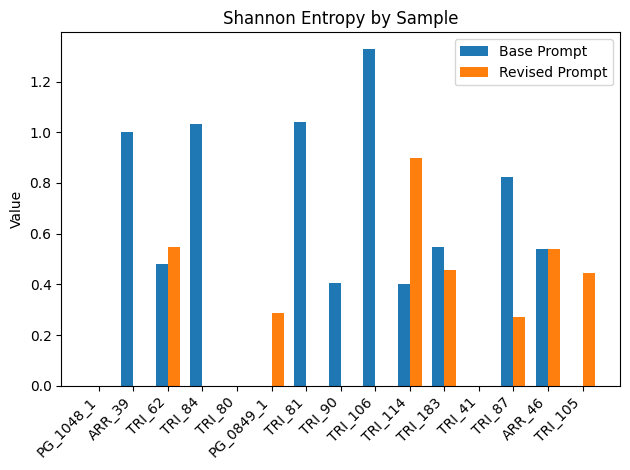

In [101]:
### Average entropy of all ranks in each sample and the prints are the averaged entropy over all samples ###
### Base prompt compared to the revised prompt ###
print(all1[1])
print(all2[1])
plot_grouped_bar_chart(all1[0],all2[0])

0.403
0.329


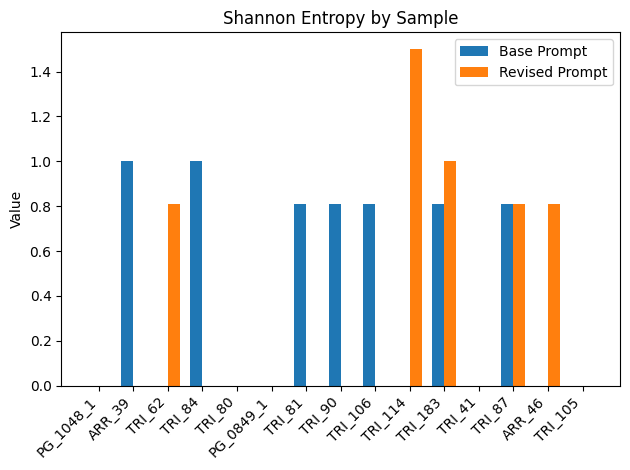

In [102]:
### Average entropy of first choice in each sample and the prints are the averaged entropy over all samples ###
### Base Prompt compared to Revised prompt ### 
print(first1[1])
print(first2[1])
plot_grouped_bar_chart(first1[0],first2[0])

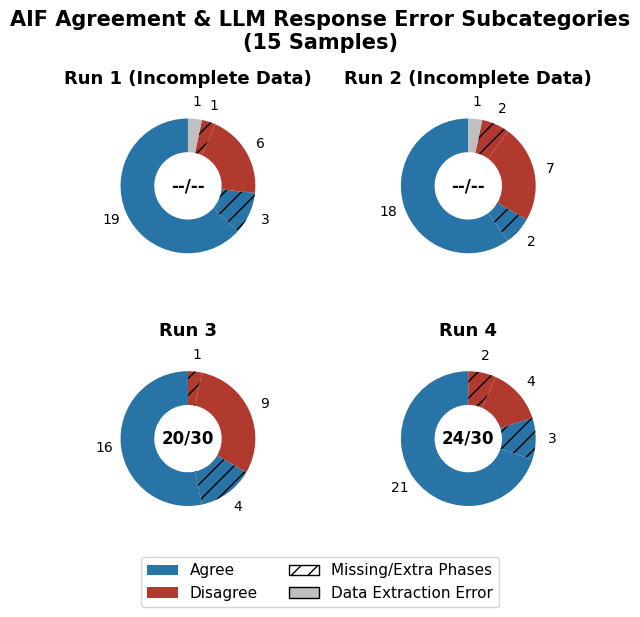

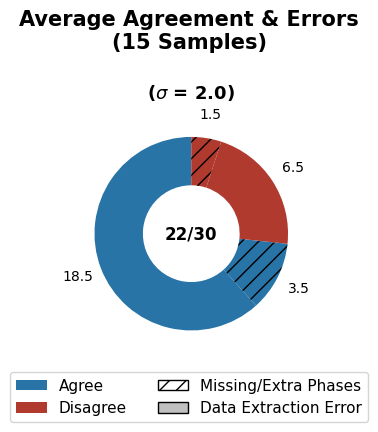

In [103]:
json_file1_path = "../Data/prompt3/moresamples/interpretations_llm_v3_llama1.json"
json_file2_path = "../Data/prompt3/moresamples/interpretations_llm_v3_llama2.json"
json_file3_path = "../Data/prompt3/moresamples/interpretations_llm_v3_llama3.json"
json_file4_path = "../Data/prompt3/moresamples/interpretations_llm_v3_llama4.json"


json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)

allgraphs_seperate_suberrors([json_file1,json_file2,json_file3,json_file4])

In [104]:
def average_diff_std(json_files1,json_files2):
    all_averages_base = []
    all_stds_base = []
    for json_file in json_files1:  # use this for the base prompt (unedited)
        diffs = {}
        all_diffs = []
        for sample in json_file:
            diffs_sample = []
            large_diff = 0
            for interpret in json_file[sample]:  # store all differences between Llama and chat GPT for each interpretation
                if interpret != "Synth_Conditions":
                    gpt_score = json_file[sample][interpret]["LLM_interpretation_likelihood"]
                    llama_score = json_file[sample][interpret]["LLM_interpretation_likelihood_llama"]
                    score_diff = abs(gpt_score - llama_score)
                    diffs_sample.append(score_diff)
                    all_diffs.append(score_diff)
            diffs[sample] = diffs_sample
        
        for sample,info in json_file.items(): # calculate the mean for each sample, not used in final product but could be useful
            average = np.mean(diffs[sample])
            std = np.std(diffs[sample])
        all_averages_base.append(round(np.mean(all_diffs),2)) # calculate the average and std of the full run including all samples
        all_stds_base.append(round(np.std(all_diffs),2))
    all_averages_revised = []
    all_stds_revised = []
    for json_file in json_files2:  # use this for the edited prompt (revised)
        diffs = {}
        all_diffs = []
        for sample in json_file:
            diffs_sample = []
            large_diff = 0
            for interpret in json_file[sample]: 
                if interpret != "Synth_Conditions":
                    gpt_score = json_file[sample][interpret]["LLM_interpretation_likelihood"]
                    llama_score = json_file[sample][interpret]["LLM_interpretation_likelihood_llama"]
                    score_diff = abs(gpt_score - llama_score)
                    diffs_sample.append(score_diff)
                    all_diffs.append(score_diff)
            diffs[sample] = diffs_sample
        
        for sample,info in json_file.items():
            average = np.mean(diffs[sample])
            std = np.std(diffs[sample])
        all_averages_revised.append(round(np.mean(all_diffs),2)) 
        all_stds_revised.append(round(np.std(all_diffs),2))
    return [all_averages_base,all_stds_base,all_averages_revised,all_stds_revised]

def table_averages_std(json_files1, json_files2):
    import pandas as pd

    results = average_diff_std(json_files1, json_files2)
    
    run_labels = ['Run 1', 'Run 2', 'Run 3', 'Run 4']
    avg_1, std_1 = results[0], results[1]
    avg_2, std_2 = results[2], results[3]

    # Build two DataFrames with custom section names as column headers
    df_base = pd.DataFrame({
        "Base Prompt": run_labels,
        "Average Diff": avg_1,
        "Std Dev": std_1
    })

    df_revised = pd.DataFrame({
        "Revised Prompt": run_labels,
        "Average Diff": avg_2,
        "Std Dev": std_2
    })

    display(df_base)
    display(df_revised)




In [105]:
json_file_path1 = "../Data/prompt3/interpretations_llm_v1_llama1.json"
json_file_path2 = "../Data/prompt3/interpretations_llm_v1_llama2.json"
json_file_path3 = "../Data/prompt3/interpretations_llm_v1_llama3.json"
json_file_path4 = "../Data/prompt3/interpretations_llm_v1_llama5.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
json_file3 = load_json(json_file_path3)
json_file4 = load_json(json_file_path4)
json_files1 = [json_file1,json_file2,json_file3,json_file4]
json_file_path1 = "../Data/prompt3/interpretations_llm_v3_llama1(183).json"
json_file_path2 = "../Data/prompt3/interpretations_llm_v3_llama2(184).json"
json_file_path3 = "../Data/prompt3/interpretations_llm_v3_llama3(185).json"
json_file_path4 = "../Data/prompt3/interpretations_llm_v3_llama4(186).json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
json_file3 = load_json(json_file_path3)
json_file4 = load_json(json_file_path4)
json_files2 = [json_file1,json_file2,json_file3,json_file4]
table_averages_std(json_files1, json_files2)

,Base Prompt,Average Diff,Std Dev
0,Run 1,0.18,0.15
1,Run 2,0.15,0.13
2,Run 3,0.16,0.13
3,Run 4,0.15,0.13


,Revised Prompt,Average Diff,Std Dev
0,Run 1,0.12,0.10
1,Run 2,0.13,0.11
2,Run 3,0.14,0.12
3,Run 4,0.12,0.09


After This all cells are using the above functions (No new functions)

In [106]:
file_path1 = "../Data/prompt3/interpretations_llm_v1_REMADE_llama1.json"
file_path2 = "../Data/prompt3/interpretations_llm_v1_REMADE_llama2.json"
file_path3 = "../Data/prompt3/interpretations_llm_v1_REMADE_llama3.json"
file_path4 = "../Data/prompt3/interpretations_llm_v1_REMADE_llama4.json"

all_runs1 = [file_path1, file_path2, file_path3, file_path4]

file_path1 = "../Data/prompt3/interpretations_llm_v3_llama1(183).json"
file_path2 = "../Data/prompt3/interpretations_llm_v3_llama2(184).json"
file_path3 = "../Data/prompt3/interpretations_llm_v3_llama3(185).json"
file_path4 = "../Data/prompt3/interpretations_llm_v3_llama4(186).json"

all_runs2 = [file_path1, file_path2, file_path3, file_path4]


first1 = first_choice_entropy(all_runs1)
all1 = all_rankings_entropy(all_runs1)
first2 = first_choice_entropy(all_runs2)
all2 = all_rankings_entropy(all_runs2)

0.376
0.23


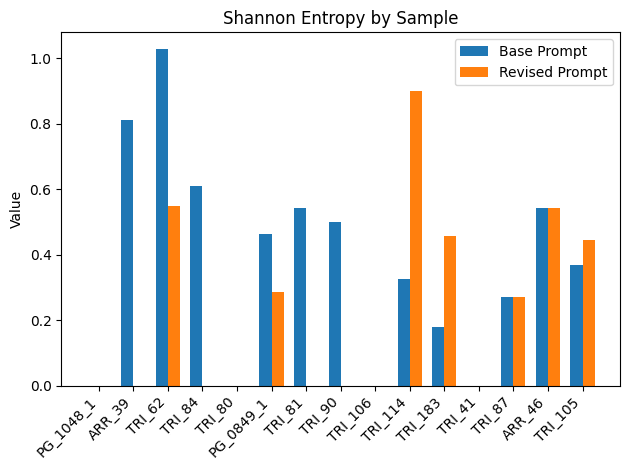

In [107]:
### Average entropy of all ranks in each sample and the prints are the averaged entropy over all samples ###
### Base prompt compared to the revised prompt ###
print(all1[1])
print(all2[1])
plot_grouped_bar_chart(all1[0],all2[0])

0.229
0.329


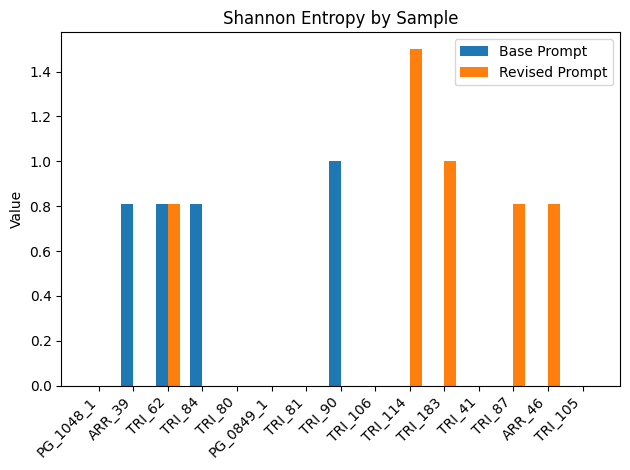

In [108]:
### Average entropy of first choice in each sample and the prints are the averaged entropy over all samples ###
### Base Prompt compared to Revised prompt ### 
print(first1[1])
print(first2[1])
plot_grouped_bar_chart(first1[0],first2[0])

No new functions after this point:

All cells are testing new data

/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_7725/1842822650.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


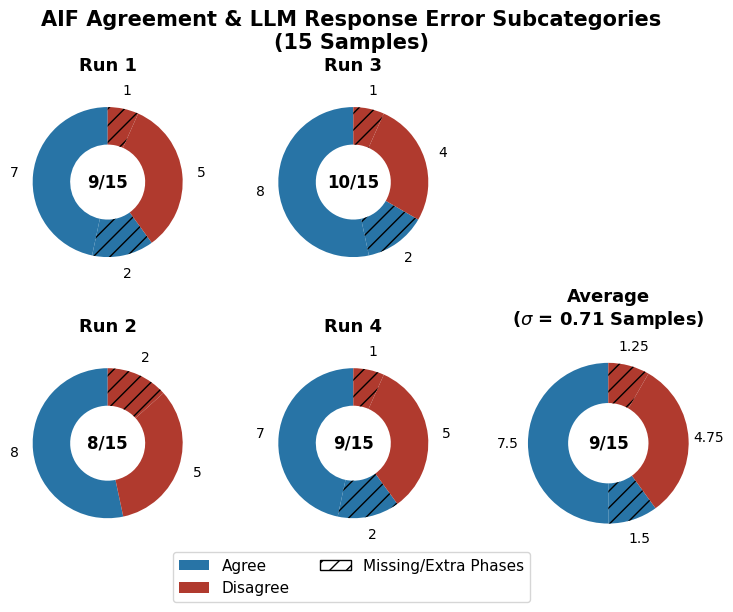

In [109]:
json_file1_path = "../Data/prompt3/interpretations_llm_v1_REMADE_llama1.json"
json_file2_path = "../Data/prompt3/interpretations_llm_v1_REMADE_llama2.json"
json_file3_path = "../Data/prompt3/interpretations_llm_v1_REMADE_llama3.json"
json_file4_path = "../Data/prompt3/interpretations_llm_v1_REMADE_llama4.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)
json_file5 = load_json(json_file5_path)

graph_all_with_suberrors([json_file1,json_file2,json_file3,json_file4],y_val=1)

/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_7725/1842822650.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


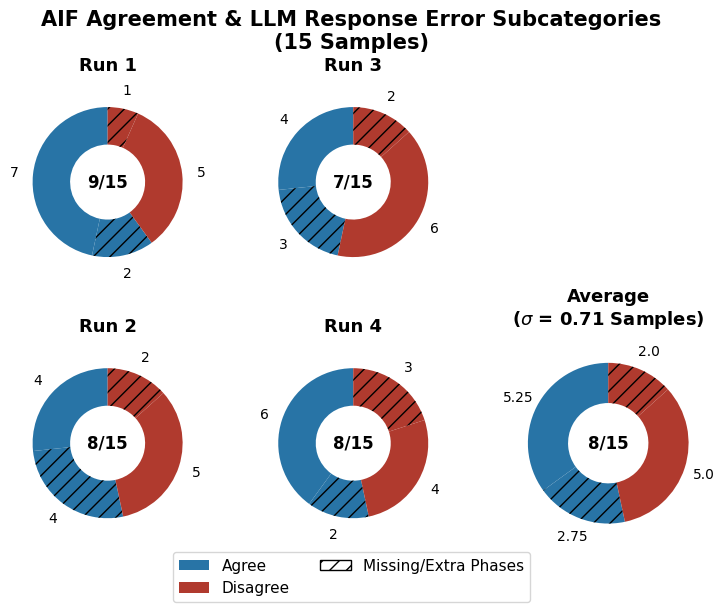

In [111]:
json_file1_path = "../Data/prompt3/Shuffled/interpretations_llm_v3_shuffle_llama1.json"
json_file2_path = "../Data/prompt3/Shuffled/interpretations_llm_v3_shuffle_llama2.json"
json_file3_path = "../Data/prompt3/Shuffled/interpretations_llm_v3_shuffle_llama3.json"
json_file4_path = "../Data/prompt3/Shuffled/interpretations_llm_v3_shuffle_llama4.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)
json_file5 = load_json(json_file5_path)

graph_all_with_suberrors([json_file1,json_file2,json_file3,json_file4],y_val=1)

/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_7725/1842822650.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


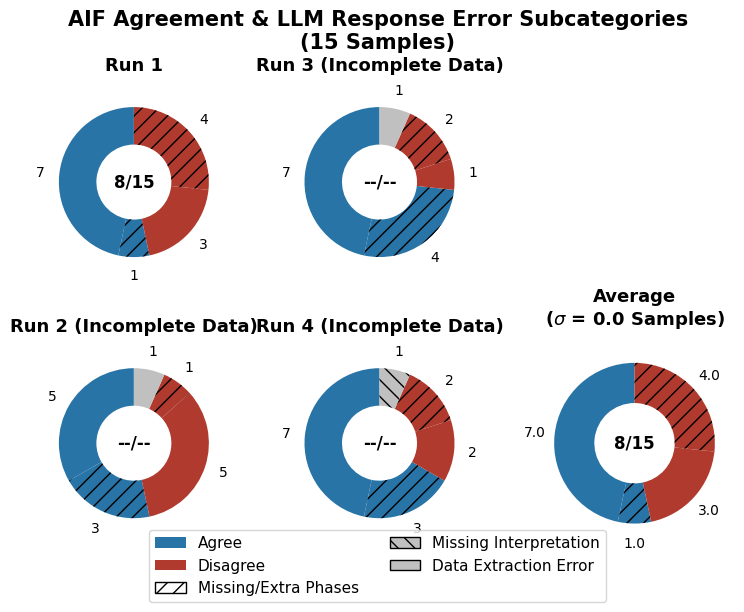

In [112]:
json_file1_path = "../Data/prompt3/Shuffled/interpretations_llm_v1_shuffle_llama1.json"
json_file2_path = "../Data/prompt3/Shuffled/interpretations_llm_v1_shuffle_llama2.json"
json_file3_path = "../Data/prompt3/Shuffled/interpretations_llm_v1_shuffle_llama3.json"
json_file4_path = "../Data/prompt3/Shuffled/interpretations_llm_v1_shuffle_llama4.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)
json_file5 = load_json(json_file5_path)

graph_all_with_suberrors([json_file1,json_file2,json_file3,json_file4],y_val=1)

/var/folders/v3/5csz6x056y7dl61fwjsm9w240000gn/T/ipykernel_7725/1842822650.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


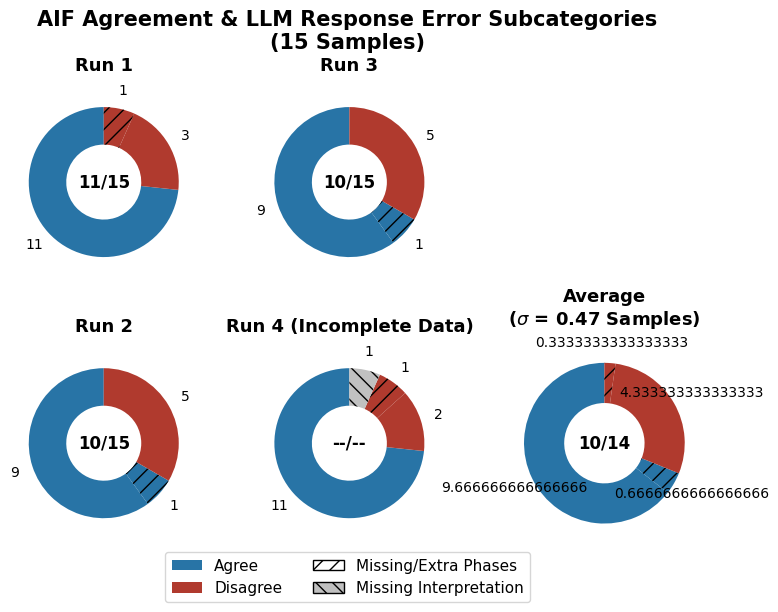

In [114]:
json_file1_path = "../Data/prompt3/Shuffled/interpretations_llm_v3_notshuffle_llama1.json"
json_file2_path = "../Data/prompt3/Shuffled/interpretations_llm_v3_notshuffle_llama2.json"
json_file3_path = "../Data/prompt3/Shuffled/interpretations_llm_v3_notshuffle_llama3.json"
json_file4_path = "../Data/prompt3/Shuffled/interpretations_llm_v3_notshuffle_llama4.json"

json_file1 = load_json(json_file1_path)
json_file2 = load_json(json_file2_path)
json_file3 = load_json(json_file3_path)
json_file4 = load_json(json_file4_path)
json_file5 = load_json(json_file5_path)

graph_all_with_suberrors([json_file1,json_file2,json_file3,json_file4],y_val=1)